In [1]:
# ===== imports =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

In [3]:
# ===== load datasets (match data prep) =====
df_fe = pd.read_csv(r"C:/Users/meria/Downloads/mlProject/eng_data.csv")         # engineered data (with Job_Growth_Rate_%)
df_ready = pd.read_csv(r"C:/Users/meria/Downloads/mlProject/prepared_data.csv")  # encoded / scaled features BEFORE PCA
X_prepared = np.load(r"C:/Users/meria/Downloads/mlProject/X_prepared.npy")

In [4]:
print("df_fe (engineered) shape:", df_fe.shape)
display(df_fe.head(3))
print("df_ready (prepared) shape:", df_ready.shape)
print("X_prepared shape:", X_prepared.shape)

df_fe (engineered) shape: (30000, 15)


,Job_Title,Industry,Job_Status,AI_Impact_Level,Median_Salary_USD,Required_Education,Experience_Required_Years,Remote_Work_Ratio_%,Automation_Risk_%,Location,Gender_Diversity_%,Job_Growth_Rate_%,Growth_Category,Vulnerability_Index,Job_Stability_Score
0,Investment analyst,IT,Increasing,Moderate,42109.76,Master’s Degree,5.0,55.96,28.28,UK,44.63,318.613861,high_growth,12.454512,390.333861
1,"Journalist, newspaper",Manufacturing,Increasing,Moderate,132298.57,Master’s Degree,15.0,16.81,89.71,USA,66.39,399.195495,high_growth,74.629749,409.485495
2,Financial planner,Finance,Increasing,Low,143279.19,Bachelor’s Degree,4.0,91.82,72.97,Canada,41.13,-65.428400,decline,5.968946,-38.398400


df_ready (prepared) shape: (30000, 665)
X_prepared shape: (30000, 665)


In [5]:
# check required columns exist
required = ['Location', 'Job_Title', 'Job_Growth_Rate_%']
missing = [c for c in required if c not in df_fe.columns]
if missing:
    raise KeyError(f"Missing required columns in eng_data.csv: {missing}")


In [7]:
# ===== Build pivot matrix: Location x Job_Title using Job_Growth_Rate_% =====
pivot_df = df_fe.pivot_table(
    values='Job_Growth_Rate_%',
    index='Location',
    columns='Job_Title',
    aggfunc='mean'
).fillna(0)

print(f"Pivot matrix shape (locations x jobs): {pivot_df.shape}")
non_zero_elements = (pivot_df != 0).sum().sum()
total_elements = pivot_df.shape[0] * pivot_df.shape[1]
print(f"Density: {non_zero_elements}/{total_elements} = {non_zero_elements/total_elements:.2%}")

# ===== Standardize rows (countries) for hierarchical clustering =====
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_df.values)   # shape (n_countries, n_jobs)
print(f"Scaled data mean: {pivot_scaled.mean():.3f}, std: {pivot_scaled.std():.3f}")
print(f"Pays analysés : {pivot_df.index.tolist()}")


Pivot matrix shape (locations x jobs): (8, 639)
Density: 5100/5112 = 99.77%
Scaled data mean: -0.000, std: 1.000
Pays analysés : ['Australia', 'Brazil', 'Canada', 'China', 'Germany', 'India', 'UK', 'USA']


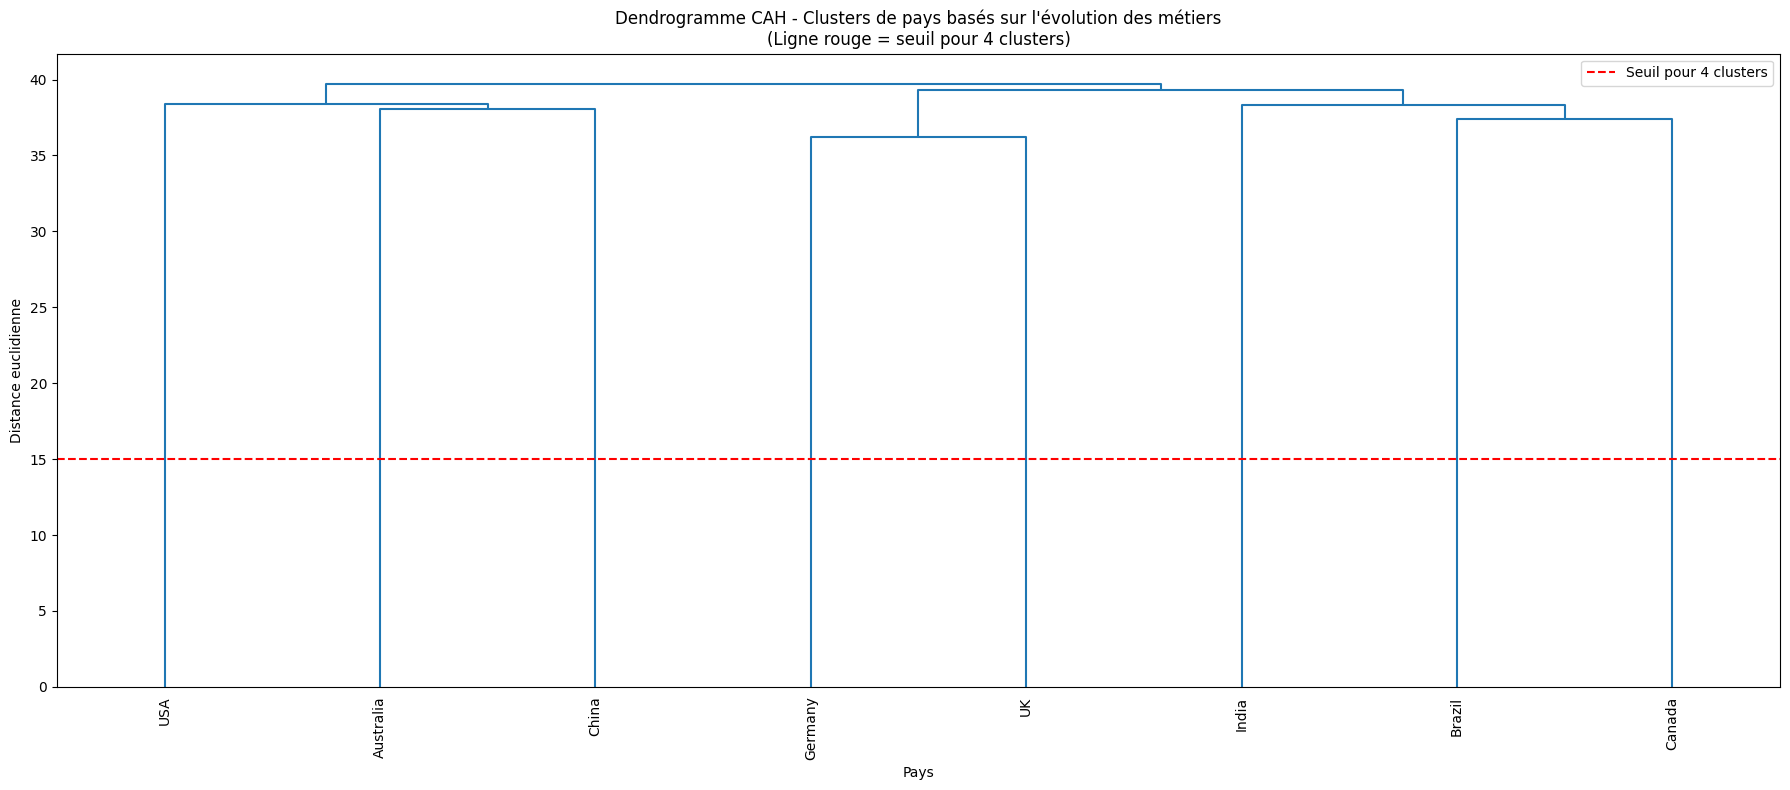

In [9]:
# Méthode 1: CAH avec scipy (pour le dendrogramme)
Z = linkage(pivot_scaled, method='ward', metric='euclidean')

# Visualisation du dendrogramme pour choisir le nombre de clusters
plt.figure(figsize=(18, 8))
dendrogram(Z,
          labels=pivot_df.index.tolist(),
          leaf_rotation=90,
          leaf_font_size=10,
          color_threshold=15)
plt.title('Dendrogramme CAH - Clusters de pays basés sur l\'évolution des métiers\n(Ligne rouge = seuil pour 4 clusters)')
plt.axhline(y=15, color='r', linestyle='--', label='Seuil pour 4 clusters')
plt.ylabel('Distance euclidienne')
plt.xlabel('Pays')
plt.legend()
plt.tight_layout()
plt.show()

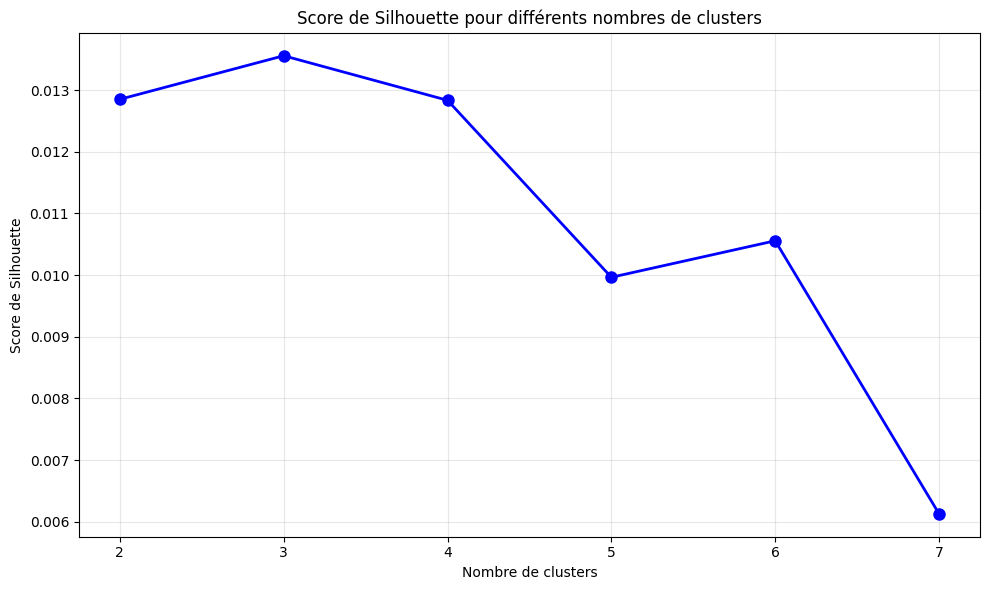

In [10]:
# Calcul du score de silhouette pour différents nombres de clusters
silhouette_scores = []
cluster_range = range(2, min(8, len(pivot_df)))  # Éviter plus de clusters que de pays

for n_clusters in cluster_range:
    # Méthode 2: CAH avec scikit-learn (plus moderne)
    hc = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='euclidean',
        linkage='ward'
    )
    cluster_labels = hc.fit_predict(pivot_scaled)

    if len(set(cluster_labels)) > 1:  # Éviter erreur si un seul cluster
        score = silhouette_score(pivot_scaled, cluster_labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(0)

# Visualisation des scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Score de Silhouette pour différents nombres de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
# Choix du nombre optimal de clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Nombre optimal de clusters (selon silhouette) : {optimal_clusters}")

# Utilisation du nombre optimal ou d'une valeur fixe selon le contexte
num_clusters = optimal_clusters  # Vous pouvez aussi utiliser une valeur fixe comme 4


Nombre optimal de clusters (selon silhouette) : 3


In [15]:
# Application de la CAH avec le nombre choisi de clusters
hc_final = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clusters = hc_final.fit_predict(pivot_scaled)

# Ajouter les clusters au DataFrame
pivot_df['Cluster'] = clusters

print(f"\n=== RÉPARTITION DES PAYS PAR CLUSTER ===")
for cluster_num in range(num_clusters):
    countries_in_cluster = pivot_df[pivot_df['Cluster'] == cluster_num].index.tolist()
    print(f"Cluster {cluster_num}: {countries_in_cluster}")



=== RÉPARTITION DES PAYS PAR CLUSTER ===
Cluster 0: ['Australia', 'China', 'USA']
Cluster 1: ['Brazil', 'Canada', 'India']
Cluster 2: ['Germany', 'UK']


In [16]:
# Application de la CAH avec le nombre choisi de clusters
hc_final = AgglomerativeClustering(
    n_clusters=num_clusters,
    metric='euclidean',
    linkage='ward'
)
clusters = hc_final.fit_predict(pivot_scaled)
# Ajouter les clusters au DataFrame
pivot_df['Cluster'] = clusters

for cluster_num in range(num_clusters):
    countries_in_cluster = pivot_df[pivot_df['Cluster'] == cluster_num].index.tolist()
    print(f"Cluster {cluster_num}: {countries_in_cluster}")

def analyze_cluster_variations(cluster_matrix, cluster_num):
    cluster_means = cluster_matrix.mean(axis=0).sort_values(ascending=False)
    top_increase = cluster_means.head(10)
    top_decrease = cluster_means.tail(10)
    print(f"\n--- Cluster {cluster_num} summary ---")
    print(f"Countries: {', '.join(cluster_matrix.index.tolist())}")
    print(f"Mean growth (all jobs): {cluster_means.mean():+.2f}%")
    print("\nTop increases (jobs):")
    print(top_increase.head(5))
    print("\nTop decreases (jobs):")
    print(top_decrease.head(5))
    return top_increase, top_decrease
print("\nDETAILED CLUSTER VARIATIONS")
for c in range(num_clusters):
    cluster_data = pivot_df[pivot_df['Cluster'] == c].drop(columns='Cluster')
    analyze_cluster_variations(cluster_data, c)

Cluster 0: ['Australia', 'China', 'USA']
Cluster 1: ['Brazil', 'Canada', 'India']
Cluster 2: ['Germany', 'UK']

DETAILED CLUSTER VARIATIONS

--- Cluster 0 summary ---
Countries: Australia, China, USA
Mean growth (all jobs): +145.35%

Top increases (jobs):
Job_Title
Corporate investment banker            930.615043
Fast food restaurant manager           836.918759
Midwife                                833.174353
Scientist, research (life sciences)    830.338993
Radiographer, therapeutic              825.239502
dtype: float64

Top decreases (jobs):
Job_Title
Planning and development surveyor   -14.845926
Acupuncturist                       -17.722892
Engineer, water                     -18.670559
Conference centre manager           -18.860748
Textile designer                    -22.730027
dtype: float64

--- Cluster 1 summary ---
Countries: Brazil, Canada, India
Mean growth (all jobs): +142.86%

Top increases (jobs):
Job_Title
Jewellery designer                     1289.223569
Ship brok

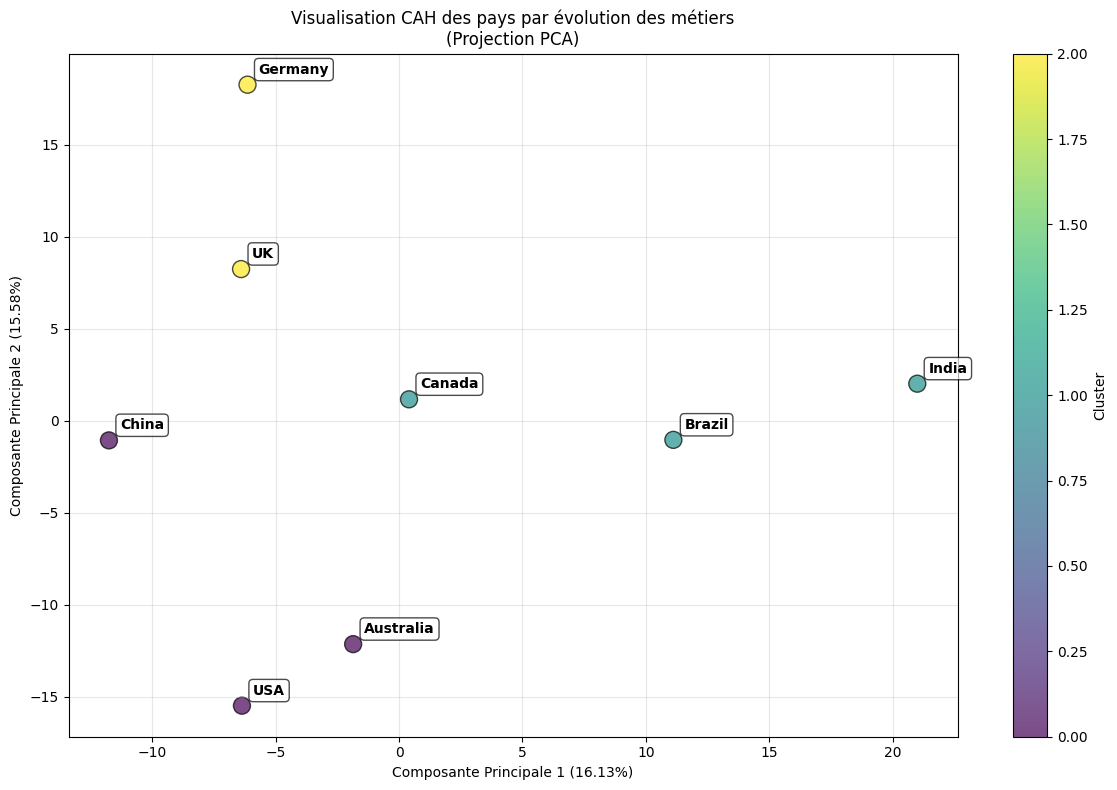

In [17]:
from sklearn.decomposition import PCA
# Réduction de dimension avec PCA
pca = PCA(n_components=2)
pivot_pca = pca.fit_transform(pivot_scaled)

# Créer un DataFrame pour la visualisation
pca_df = pd.DataFrame({
    'PC1': pivot_pca[:, 0],
    'PC2': pivot_pca[:, 1],
    'Cluster': clusters,
    'Country': pivot_df.index
})

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'],
                     cmap='viridis', s=150, alpha=0.7, edgecolors='black')
# Ajouter les labels des pays
for i, country in enumerate(pca_df['Country']):
    plt.annotate(country, (pca_df['PC1'][i], pca_df['PC2'][i]),
                xytext=(8, 8), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

plt.colorbar(scatter, label='Cluster')
plt.title('Visualisation CAH des pays par évolution des métiers\n(Projection PCA)')
plt.xlabel(f'Composante Principale 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Composante Principale 2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Calcul des statistiques globales
cluster_stats = []
for cluster_num in range(num_clusters):
    cluster_data = pivot_df[pivot_df['Cluster'] == cluster_num].drop('Cluster', axis=1)
    countries = cluster_data.index.tolist()
    mean_growth = cluster_data.values.mean()
    std_growth = cluster_data.values.std()

    cluster_stats.append({
        'Cluster': cluster_num,
        'Pays': countries,
        'Croissance Moyenne': mean_growth,
        'Variabilité': std_growth
    })

# Tri par croissance moyenne
cluster_stats_sorted = sorted(cluster_stats, key=lambda x: x['Croissance Moyenne'], reverse=True)

for i, stats in enumerate(cluster_stats_sorted, 1):
    print(f"\n{i}. Cluster {stats['Cluster']}:")
    print(f"   Pays: {', '.join(stats['Pays'])}")
    print(f"   Croissance moyenne: {stats['Croissance Moyenne']:+.1f}%")
    print(f"   Variabilité: {stats['Variabilité']:.1f}%")

# Identification des tendances globales
most_growth_cluster = cluster_stats_sorted[0]
least_growth_cluster = cluster_stats_sorted[-1]

print(f"\n CONCLUSIONS STRATÉGIQUES:")
print(f"• Le cluster le plus dynamique est le Cluster {most_growth_cluster['Cluster']} "
      f"({most_growth_cluster['Croissance Moyenne']:+.1f}%)")
print(f"• Le cluster le plus en difficulté est le Cluster {least_growth_cluster['Cluster']} "
      f"({least_growth_cluster['Croissance Moyenne']:+.1f}%)")
print(f"• Score de silhouette moyen: {silhouette_score(pivot_scaled, clusters):.3f}")

print(f"\nANALYSE TERMINÉE AVEC SUCCÈS!")
print(f"• {len(pivot_df)} pays analysés")
print(f"• {pivot_df.shape[1]-1} métiers considérés")
print(f"• {num_clusters} clusters identifiés")



1. Cluster 0:
   Pays: Australia, China, USA
   Croissance moyenne: +145.3%
   Variabilité: 253.9%

2. Cluster 1:
   Pays: Brazil, Canada, India
   Croissance moyenne: +142.9%
   Variabilité: 248.9%

3. Cluster 2:
   Pays: Germany, UK
   Croissance moyenne: +124.4%
   Variabilité: 213.4%

 CONCLUSIONS STRATÉGIQUES:
• Le cluster le plus dynamique est le Cluster 0 (+145.3%)
• Le cluster le plus en difficulté est le Cluster 2 (+124.4%)
• Score de silhouette moyen: 0.014

ANALYSE TERMINÉE AVEC SUCCÈS!
• 8 pays analysés
• 639 métiers considérés
• 3 clusters identifiés
